In [1]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from disparity import *

Calibration with checker board

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((7*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:7].T.reshape(-1,2)

calibdatapath = 'checkerboard'

cameras = ['col', 'ir1', 'ir2']

imgpoints = {}

mtx_map = {}
dist_map = {}

for cam in cameras:

    objpoints = [] # 3d point in real world space
    imgpoints[cam] = [] # 2d points in image plane.

    images = glob.glob(calibdatapath + '/' + cam + '/*.png')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (9,7), flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FILTER_QUADS)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(7,7),(-1,-1),criteria)
            imgpoints[cam].append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,7), corners2,ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(300)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints[cam], gray.shape[::-1],None,None,
                                                        flags=cv2.CALIB_FIX_K3 + cv2.CALIB_ZERO_TANGENT_DIST)

    # print('intrinsic of {}: \n{}\ndistortion coefficients of {}: \n{}\nret:{}\n'.format(cam, mtx, cam, dist,ret))
    print("---instrincs of {}---".format(cam))
    print("instrinc matrix: {}".format(mtx))
    print("distortion coefficient: {}".format(dist))
    print("retval: {}".format(ret))

    mtx_map[cam] = mtx
    dist_map[cam] = dist


# extrinstic calibration
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

ret_r1c, M1_r1c, d1_r1c, M2_r1c, d2_r1c, R_r1c, T_r1c, E_r1c, F_r1c  = cv2.stereoCalibrate(objpoints, imgpoints['ir1'], imgpoints['col'],
    mtx_map['ir1'], dist_map['ir1'], mtx_map['col'], dist_map['col'], gray.shape[::-1], criteria=stereocalib_criteria, flags=None)

print("---Calib ir1 and col---")
print('F\n', F_r1c)
print('R\n', R_r1c)
print('T\n', T_r1c)
print('ret\n', ret_r1c)

ret_r12, M1_r12, d1_r12, M2_r12, d2_r12, R_r12, T_r12, E_r12, F_r12 = cv2.stereoCalibrate(objpoints, imgpoints['ir1'], imgpoints['ir2'],
    mtx_map['ir1'], dist_map['ir1'], mtx_map['ir2'], dist_map['ir2'], gray.shape[::-1], criteria=stereocalib_criteria, flags=None)

print("---Calib ir1 and ir2---")
print('F\n', F_r12)
print('R\n', R_r12)
print('T\n', T_r12)
print('ret\n', ret_r12)

ret_r2c, M1_r2c, d1_r2c, M2_r2c, d2_r2c, R_r2c, T_r2c, E_r2c, F_r2c = cv2.stereoCalibrate(objpoints, imgpoints['col'], imgpoints['ir2'],
    mtx_map['col'], dist_map['col'], mtx_map['ir2'], dist_map['ir2'], gray.shape[::-1], criteria=stereocalib_criteria, flags=None)

print("---Calib ir2 and col---")
print('F\n', F_r2c)
print('R\n', R_r2c)
print('T\n', T_r2c)
print('ret\n', ret_r2c)





---instrincs of col---
instrinc matrix: [[630.37303637   0.         323.41633417]
 [  0.         628.91433048 241.26197424]
 [  0.           0.           1.        ]]
distortion coefficient: [[ 0.14314066 -0.33876348  0.          0.          0.        ]]
retval: 0.17834112918123574
---instrincs of ir1---
instrinc matrix: [[386.19680825   0.         321.16097031]
 [  0.         385.53912198 244.9460883 ]
 [  0.           0.           1.        ]]
distortion coefficient: [[-0.00129569  0.00050405  0.          0.          0.        ]]
retval: 0.2892463710512834
---instrincs of ir2---
instrinc matrix: [[384.12886476   0.         320.68896748]
 [  0.         383.81934245 247.17914093]
 [  0.           0.           1.        ]]
distortion coefficient: [[-0.00216601  0.0069984   0.          0.          0.        ]]
retval: 0.44060171196748116
---Calib ir1 and col---
F
 [[ 7.31771589e-07  6.31651821e-05 -1.73821484e-02]
 [-6.35933647e-05  5.07808245e-07  2.63013125e-02]
 [ 1.80110107e-02 -3.13

Stereo Camera Parameters

In [2]:
K_col = np.array([[662.593701688052, 0.0, 324.857607968018],
                [0.0, 658.422641634482, 224.715217487322],
                [0.0, 0.0, 1.000000]])
d_col = np.array([0.155208391239907,-0.360250096753537,0.0,0.0,0.0])

K_ir1 = np.array([[388.425466037048, 0.0, 321.356734811229],
                [0.0, 387.559412128232, 244.543659354387],
                [0.0, 0.0, 1.000000]])
d_ir1 = np.array([0.00143845958426059,-0.00410315309358759,0.0,0.0,0.0])

K_ir2 = np.array([[390.034619271096, 0.0, 321.390633361907],
                [0.0, 389.119919973996, 244.648608218415],
                [0.0, 0.0, 1.000000]])
d_ir2 = np.array([0.00241762888488943,-0.00118610336539317,0.0,0.0,0.0])

# ir1 to ir2
R_12 = np.array([[0.999999506646425, -3.18339774658664e-05, 0.000992820983631579],
                [3.15905844318835e-05, 0.999999969447414, 0.000245167709718939],
                [-0.000992828757961677, -0.000245136224969466, 0.999999477099508]])
T_12 = np.array([-49.9430087222935, 0.0126441058712290, -0.0678600809461142]).reshape(3,-1)

# col to ir1
R_c1 = np.array([[0.999910747799202, 0.00771026073417451, -0.0109109264066290],
                [-0.00752421415642894, 0.999827332294842, 0.0169909328027827],
                [0.0110400469640315, -0.0169073201777079, 0.999796109157982]])
T_c1 = np.array([-12.5244317709951, -0.348306884717175, -0.914268234792363]).reshape(3, -1)

# F ir1 ir2
F = np.array([[ 7.31771135e-07,  6.31651479e-05, -1.73821388e-02],
 [-6.35933304e-05,  5.07808012e-07,  2.63013020e-02],
 [ 1.80110007e-02, -3.13940386e-02,  1.00000000e+00]])

K = [K_col, K_ir1, K_ir2]
d = [d_col, d_ir1, d_ir2]



Undistort Images

In [3]:
for i, cam in enumerate(cameras):

    images = glob.glob(scenedatapath + '/' + cam + '/*.png')

    path = scenedatapath + '/' + cam + "/undist/"
    if not os.path.exists(path):
        os.mkdir(path)

    for file_name in images:
        img = cv2.imread(file_name)
        undist_img = cv2.undistort(img, K[i], d[i], None, K[i])
        file_name_ = file_name.split('/')[-1]
        file_path = path + file_name_
        #cv2.imshow('img', undist_img)
        #cv2.waitKey(500)
        cv2.imwrite(file_path, undist_img)

NameError: name 'cameras' is not defined

In [45]:
def FindAndMatchFeatures(img1, img2, des = 'sift', mat = 'bruteforce', filter = False, maxNumPoints = 100):
    # Initiate ORB detector
    if des == 'orb':
        descriptor = cv2.ORB_create()
    else:
        descriptor = cv2.SIFT_create()
 
    # find the keypoints and descriptors with ORB
    kp1, des1 = descriptor.detectAndCompute(img1,None)
    kp2, des2 = descriptor.detectAndCompute(img2,None)
    # create BFMatcher object
    if mat == 'bruteforce':
        if des == 'orb':
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        else:
            matcher = cv2.BFMatcher()
    else:
        search_params = dict(checks=50)
        if des == 'orb':
            FLANN_INDEX_LSH = 6
            index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1)
        else:
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    if des == 'orb':
        matches = matcher.match(des1,des2)
    else:
        matches = []
        res = matcher.knnMatch(des1, des2, k=2)
        for m,n in res:
            if m.distance < 0.75*n.distance:
                matches.append(m)
    l = len(matches)
    print(l)
    matches = sorted(matches, key = lambda x:x.distance)
    if filter and l > maxNumPoints:
        matches = matches[:100]
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    return matches, src_pts, dst_pts

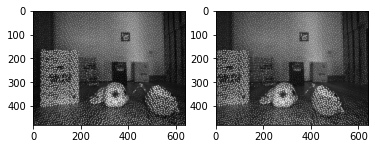

1669
[[-1.55805847e-08 -3.09931674e-05  1.28409243e-02]
 [ 3.37524693e-05 -3.82310547e-08  3.26718666e-01]
 [-1.41705510e-02 -3.29600190e-01  1.00000000e+00]]


In [78]:
scenedatapath = 'dataset-stereo/scene'
undist_images_1 = glob.glob(scenedatapath + '/ir1/undist/' + '*.png')
undist_images_2 = glob.glob(scenedatapath + '/ir2/undist/' + '*.png')

i = 3
img1 = cv2.imread(undist_images_1[i], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(undist_images_2[i], cv2.IMREAD_GRAYSCALE)

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1, cmap = 'gray')
ax[1].imshow(img2, cmap = 'gray')
plt.show()

h, w = img1.shape

_, kp1, kp2 = FindAndMatchFeatures(img1, img2, 'sift', 'flann', filter=True, maxNumPoints=50)

F, mask = cv2.findFundamentalMat(kp1, kp2, cv2.FM_LMEDS, ransacReprojThreshold=1, confidence=0.9999)

print(F)


Disparity estimation

(640, 480)


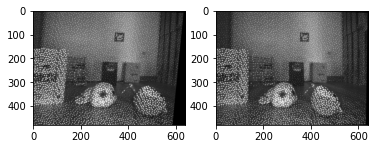

In [79]:
size = (w, h)
print(size)
retval, H1, H2 = cv2.stereoRectifyUncalibrated(kp1, kp2, F, size, threshold = 1)
rect_1 = cv2.warpPerspective(img1, H1, size)
rect_2 = cv2.warpPerspective(img2, H2, size)
f, ax = plt.subplots(1, 2)
ax[0].imshow(rect_1, cmap = 'gray')
ax[1].imshow(rect_2, cmap = 'gray')
plt.show()


In [82]:
dispMap = BlockMatching2(img1, img2, window_size=21)

(480, 640)


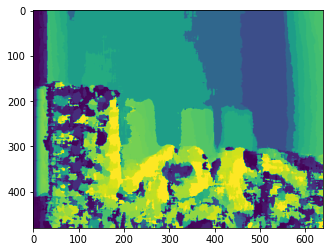

In [83]:
print(dispMap.shape)
plt.imshow(dispMap)
plt.show()

In [56]:
dispMap = ComputeDisparity(rect_1, rect_2)

KeyboardInterrupt: 

(480, 640)


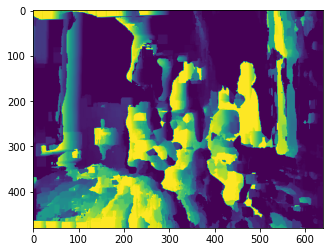

In [18]:
print(dispMap.shape)
plt.imshow(dispMap)
plt.show()

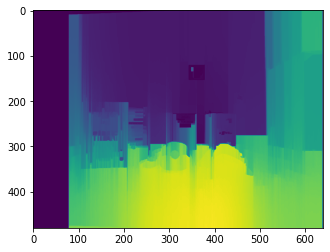

In [15]:
dm = DepthMapBuiltIn(rect_1, rect_2)
plt.imshow(dm)
plt.show()

In [62]:
undist_images_1 = glob.glob(scenedatapath + '/ir1/undist/' + '*.png')
undist_images_2 = glob.glob(scenedatapath + '/ir2/undist/' + '*.png')

w, h = 640, 480

# Rectify stereo pair to bring them into the same image plane
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(K_ir1, d_ir1, K_ir2, d_ir2, (w, h), R_12, T_12, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.9)

stereo = cv2.StereoBM_create(numDisparities=48, blockSize=21)

gray_rect_1 = []
gray_rect_2 = []
disparity = []

for i in range(len(undist_images_1)):

    img1 = cv2.imread(undist_images_1[i])
    img2 = cv2.imread(undist_images_2[i])
    mapx_1, mapy_1 = cv2.initUndistortRectifyMap(K_ir1, d_ir1, R1, P1, (w, h), cv2.CV_32FC1)
    rect_1 = cv2.remap(img1, mapx_1, mapy_1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    mapx_2, mapy_2 = cv2.initUndistortRectifyMap(K_ir2, d_ir2, R2, P2, (w, h), cv2.CV_32FC1)

    rect_2 = cv2.remap(img2, mapx_2, mapy_2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    gray_1 = cv2.cvtColor(rect_1, cv2.COLOR_BGR2GRAY)
    gray_2 = cv2.cvtColor(rect_2, cv2.COLOR_BGR2GRAY)

    d = stereo.compute(gray_1, gray_2)

    gray_rect_1.append(gray_1)
    gray_rect_2.append(gray_2)
    disparity.append(d)


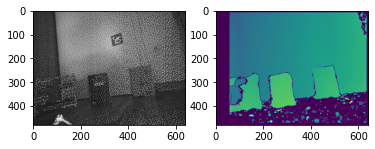

In [85]:
idx = 0
f, ax = plt.subplots(1, 2)
ax[0].imshow(gray_rect_1[idx], cmap = 'gray')
ax[1].imshow(disparity[idx])
plt.show()

Create Point Cloud

In [88]:
from ply_writer import write_ply

In [92]:
for i in range(len(disparity)):
    points = cv2.reprojectImageTo3D(disparity[i], Q)
    img = cv2.imread(undist_images_1[i])
    colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask1 = disparity[i] >= 200
    mask2 = disparity[i] <= 800
    mask = np.all([mask1, mask2], axis=0)
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = 'pointcloud_{}.ply'.format(i)
    write_ply(out_fn, out_points, out_colors)

pointcloud_0.ply saved
pointcloud_1.ply saved
pointcloud_2.ply saved
pointcloud_3.ply saved
pointcloud_4.ply saved
pointcloud_5.ply saved
